### Generate RF Features
- notebook to load data (currently: DroneDetect dataset)
- generate RF-based features: PSD, spectrograms in array form


In [1]:
import os
import numpy as np
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
import os
from sklearn.model_selection import train_test_split
from spafe.features.lfcc import lfcc
import spafe.utils.vis as vis
from scipy.signal import get_window
import scipy.fftpack as fft
from scipy import signal
import matplotlib.pyplot as plt
from datetime import date
from tqdm import tqdm
from loading_functions import *
from scipy import interpolate


In [2]:
# Reload modules for testing
# import importlib
# import helper_functions
# importlib.reload(helper_functions)
# from helper_functions import *

In [3]:
# Data paths

# DroneDetect
main_folder = '/home/ltindall/data/DroneDetect/DroneDetect_V2/' # data path on mp-gpu-desktop06
sub_folders = os.listdir(main_folder)

# Dataset Info
fs = 60e6 #60 MHz
bandwidth = 28e6 # 28MHz
center_freq = 2.43e9


In [9]:
## DATA SAVING FUNCTIONS
def interpolate_2d(Sxx_in, output_size):
    x = np.linspace(0, 1, Sxx_in.shape[0])
    y = np.linspace(0, 1, Sxx_in.shape[1])
    f = interpolate.interp2d(y, x, Sxx_in, kind='linear')
    
    x2 = np.linspace(0, 1, output_size[0])
    y2 = np.linspace(0, 1, output_size[1])
    arr2 = f(y2, x2)
    
    return arr2

# save function to save image to file
def save_spec_image(folder_path, cond_folder, DRONE, COND, INT, FIn, counter, f, t, Sxx):
    plt.clf()
    plt.pcolormesh(t, f, Sxx, cmap='Greys', vmin=Sxx.min(), vmax=Sxx.max())
    full_img_path = folder_path+cond_folder+DRONE+'_'+COND+'_'+INT+'_'+FIn+'_'+str(counter)+'.jpg'
    plt.savefig(full_img_path)

# save spectrogram when passing in fig object
def save_spec_image_fig(folder_path, cond_folder, DRONE, COND, INT, FIn, counter, fig, dpi):
    full_img_path = folder_path+"/"+cond_folder+"/"+DRONE+'_'+COND+'_'+INT+'_'+FIn+'_'+str(counter)+'.jpg'
    fig.savefig(full_img_path, dpi=dpi)
    
def save_psd_image(folder_path, cond_folder, DRONE, COND, INT, FIn, counter, PSD, dim_px, dpi):
#     plt.clf()
#     plt.plot(f, PSD, 'k')
    fig = plot_feat(PSD, dim_px, dpi)
    full_img_path = folder_path+"/"+cond_folder+"/"+DRONE+'_'+COND+'_'+INT+'_'+FIn+'_'+str(counter)+'.jpg'
    fig.savefig(full_img_path)    

def save_array(folder_path, feat, DRONES, CONDS, INTS, feat_name, int_name):
    Xs_arr = np.array(feat)
    
    # labels
    y_drones_arr = np.array(DRONES)
    y_conds_arr = np.array(CONDS)
    y_ints_arr = np.array(INTS)

    data_save = {'feat': Xs_arr, 'drones': y_drones_arr, 'conds': y_conds_arr, 'ints': y_ints_arr}
#     return data_save

#     #Save data
    date_string = date.today()
    fp = folder_path+"/"+int_name+"_"+feat_name+"_"+str(n_per_seg)
    print(fp)
    np.save(fp, data_save)

In [ ]:
# Specifications on what features to generate
n_per_seg = 512 # length of each segment (powers of 2)
n_overlap_spec = 120
win_type = 'hamming' # make ends of each segment match
t_seg = 20 # sample length in milliseconds
feature_to_save = ['SPEC'] # what features to generate and save: SPEC or PSD
format_to_save = ['IMG'] # IMG or ARR
inteference_folders = ['WIFI', 'BLUE', 'BOTH', 'CLEAN'] # options: ['WIFI', 'BLUE', 'BOTH', 'CLEAN']

# Image properties
dim_px = (224, 224) # dimension of image pixels
dpi = 100

# data saving folders
features_folder = '../Features/testtest/'
date_string = date.today()
# folder naming: DATATYPE_FEAT_NFFT_SAMPLELENGTH
arr_spec_folder = "ARR_SPEC_"+str(n_per_seg)+"_"+str(t_seg)
arr_psd_folder = "ARR_PSD_"+str(n_per_seg)+"_"+str(t_seg)
img_spec_folder = "IMG_SPEC_"+str(n_per_seg)+"_"+str(t_seg)
img_psd_folder = "IMG_PSD_"+str(n_per_seg)+"_"+str(t_seg)

# check if this set of parameters already exists
existing_folders = os.listdir(features_folder)

# check if each of the 4 folders exist
sa_save = False   #spec array
si_save = False   #spec imag
pa_save = False   #psd array
pi_save = False   #psd imag
if 'SPEC' in feature_to_save:
    if 'ARR' in format_to_save:
        if arr_spec_folder not in existing_folders:
            os.mkdir(features_folder+arr_spec_folder)
            sa_save = True
            print('Generating SPEC in ARRAY format')
        else:
            print('Spec Arr folder already exists')
    if 'IMG' in format_to_save:
        if img_spec_folder not in existing_folders:
            os.mkdir(features_folder+img_spec_folder)
            si_save = True
            print('Generating SPEC in IMAGE format')
        else:
            print('Spec Arr folder already exists')
if 'PSD' in feature_to_save:
    if 'ARR' in format_to_save:
        if arr_psd_folder not in existing_folders:
            os.mkdir(features_folder+arr_psd_folder)
            pa_save = True
            print('Generating PSD in ARRAY format')
        else:
            print('PSD Arr folder already exists')
    if 'IMG' in format_to_save:
        if img_psd_folder not in existing_folders:
            os.mkdir(features_folder+img_psd_folder)
            pi_save = True
            print('Generating PSD in IMAGE format')
        else:
            print('PSD Arr folder already exists')            
            
if all([not sa_save, not si_save, not pa_save, not pi_save]):
    print('Features Already Exist - Do Not Generate')
else:
    ## Generate features

    # loop through all files
    for sf in inteference_folders: # options: ['WIFI', 'BLUE', 'BOTH', 'CLEAN']
        print('current folder: ', sf)

        drone_folders = os.listdir(main_folder+sf+'/')
        for df in drone_folders:
            print('     subfolder:', df)
            # reset lists -  to save memory
            DRONES = []
            CONDS =[]
            INTS = [] # interferences: 00 for a clean signal, 01 for Bluetooth only, 10 for Wi-Fi only and 11 for Bluetooth and Wi-Fi interference concurrently.

            # features
            F_PSD = []
#             F_PSD_freq = []

            F_SPEC = []
#             F_SPEC_freq = []
#             F_SPEC_time = []

            files = os.listdir(main_folder+sf+'/'+df+'/')
            
            #labels (from folder name)
            drone_name = df[:3]
            cond_name = df[4:]

            for fi in tqdm(files):
                d_split, _ = load_dronedetect_raw(main_folder+sf+'/'+df+'/'+fi, t_seg)
                
                # labels (from file name)
                fi_number = fi[-6:-4]
                int_name = fi[4:6]
                for i in range(len(d_split)): # for each split based on t_seg

                    d_complex = d_split[i]

                    # save labels
                    DRONES.append(drone_name)
                    CONDS.append(cond_name)
                    INTS.append(int_name)

                    # calculate PSD
                    if pa_save or pi_save:
                        fpsd, Pxx_den = signal.welch(d_complex, fs, window=win_type, nperseg=n_per_seg)
                        if pa_save:
                            F_PSD.append(Pxx_den)
                            F_PSD_freq.append(fpsd)
                        
                        if pi_save:
                            save_psd_image(features_folder, img_psd_folder, drone_name, 
                                           cond_name, int_name, fi_number, i, Pxx_den, dim_px, dpi)

                    # calculate spectrogram
                    if sa_save or si_save:
#                         fspec, t, Sxx = signal.spectrogram(d_complex, fs, window=win_type, nperseg=n_per_seg, noverlap =0) ## using minimal overlap
                        if si_save: # set up fig properties if saving images
                            fig,ax = plt.subplots(1, figsize=(dim_px[0]/dpi, dim_px[1]/dpi), dpi=dpi)
                            fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
                            ax.axis('tight')
                            ax.axis('off')
                        han_window = np.hanning(n_per_seg)
                        spec, freqs, bins, im = plt.specgram(d_complex, NFFT=n_per_seg, Fs=fs, window=han_window, 
                                          noverlap=n_overlap_spec, sides='onesided')
                        if si_save:
                            save_spec_image_fig(features_folder, img_spec_folder, 
                                                drone_name, cond_name, int_name, fi_number, i, fig, dpi)
                        if sa_save:
                            F_SPEC.append(interpolate_2d(sp[0], (224,224))) # reshape to square?
#                         F_SPEC_freq.append(fspec)
#                         F_SPEC_time.append(t)

                    # save the images 
    #                 save_spec_image(features_folder, img_spec_folder, drone_name, 
    #                                 cond_name, int_name, fi_number, i, fspec, t, Sxx)

    #                 # save the images 
    #                 save_psd_image(features_folder, img_psd_folder, drone_name, 
    #                                 cond_name, int_name, fi_number, i, fpsd, Pxx_den)

            # save data array
            if sa_save:
                save_array(features_folder+arr_spec_folder, F_SPEC, DRONES, CONDS, INTS, 'SPEC'+"_"+df, sf)
            if pa_save:
                save_array(features_folder+arr_psd_folder, F_PSD, DRONES, CONDS, INTS, 'PSD'+"_"+df, sf)



Generating SPEC in IMAGE format
current folder:  WIFI
     subfolder: AIR_FY


  0%|                                                                                                                                      | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_971760/3109422318.py:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1, figsize=(dim_px[0]/dpi, dim_px[1]/dpi), dpi=dpi)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.16s/it]


     subfolder: MP1_ON


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.28s/it]


     subfolder: MIN_FY


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.97s/it]


     subfolder: PHA_FY


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.85s/it]


     subfolder: MP2_ON


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.96s/it]


     subfolder: MIN_HO


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.60s/it]


     subfolder: AIR_HO


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.15s/it]


     subfolder: MP1_FY


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.29s/it]


     subfolder: DIS_FY


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.67s/it]


     subfolder: MIN_ON


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.52s/it]


     subfolder: DIS_ON


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.73s/it]


     subfolder: INS_FY


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.30s/it]


     subfolder: INS_HO


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.20s/it]


     subfolder: MP2_FY


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.99s/it]


     subfolder: MP1_HO


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.89s/it]


     subfolder: MP2_HO


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.26s/it]


     subfolder: PHA_ON


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.98s/it]


     subfolder: PHA_HO


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.36s/it]


     subfolder: INS_ON


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.63s/it]


     subfolder: AIR_ON


 20%|█████████████████████████▏                                                                                                    | 1/5 [00:10<00:40, 10.03s/it]

In [18]:
fpsd, Pxx_den = signal.welch(d_complex, fs, window=win_type, nperseg=n_per_seg)

/home/kzhou/.pyenv/versions/3.8.2/envs/main/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:1814: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


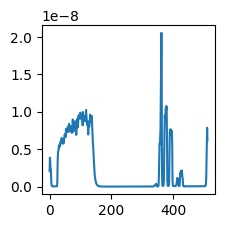

In [36]:
fig = plot_feat(Pxx_den, (224,224), 100)

In [41]:
fig.savefig('saved.jpeg')

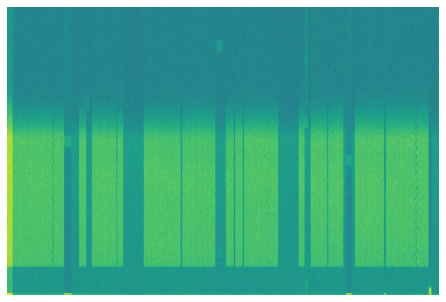

In [57]:
fig,ax = plt.subplots(1)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
ax.axis('tight')
ax.axis('off')

han_window = np.hanning(n_per_seg)
spec, freqs, bins, im = plt.specgram(d_complex, NFFT=n_per_seg, Fs=fs, window=han_window, 
                  noverlap=n_overlap_spec, sides='onesided')

In [53]:
# im.axis('off')
fig.savefig('sp_xyz.jpeg', dpi=300, frameon='false')

/tmp/ipykernel_966232/3252065198.py:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('sp_xyz.jpeg', dpi=300, frameon='false')


In [58]:
plt.show()

In [40]:
sp

(array([[6.72113371e-06, 6.93242680e-06, 6.78941552e-06, ...,
         2.51285332e-10, 2.72264977e-10, 1.46599068e-10],
        [3.49353247e-06, 3.65622718e-06, 3.57279992e-06, ...,
         1.55194557e-10, 1.29404807e-10, 8.16930634e-11],
        [1.81344909e-09, 2.24953691e-09, 2.34818657e-09, ...,
         6.24893119e-12, 2.09387459e-11, 4.69305363e-12],
        ...,
        [2.09565386e-11, 2.85386489e-11, 2.35594933e-11, ...,
         9.97949899e-13, 4.46178628e-13, 1.07567612e-12],
        [1.71217638e-11, 2.27981477e-11, 2.65889234e-11, ...,
         2.55737908e-12, 2.45553556e-12, 1.49899238e-12],
        [1.32578482e-11, 2.21960381e-11, 5.11664552e-12, ...,
         3.29555235e-12, 1.71317451e-12, 1.66996359e-12]]),
 array([       0. ,   117187.5,   234375. ,   351562.5,   468750. ,
          585937.5,   703125. ,   820312.5,   937500. ,  1054687.5,
         1171875. ,  1289062.5,  1406250. ,  1523437.5,  1640625. ,
         1757812.5,  1875000. ,  1992187.5,  2109375. ,  2226

In [7]:
img_spec_folder

'IMG_SPEC_1024_20/'

In [7]:
sa_save = False
si_save = False
pa_save = False
pi_save = False
all([not sa_save, not si_save, not pa_save, not pi_save])

True

## Load Files test

In [46]:
from loading_functions import *

In [47]:
feat_folder = '../Features/'
feat_name = 'PSD'
# datestr = '2022-06-29'
n_per_seg = 512
interferences = ['WIFI']
seg_len = 200
output_feat = 'drones'
# (feat_folder, feat_name, seg_len, n_per_seg, output_feat, interferences)
Xs_arr, y_arr = load_dronedetect_features(feat_folder, feat_name, seg_len, n_per_seg, output_feat, interferences)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 3199.04it/s]


In [35]:
Xs_arr.shape

(1000, 512)

## Plot as images test

In [48]:
import importlib
# import loading_functions
# importlib.reload(loading_functions)

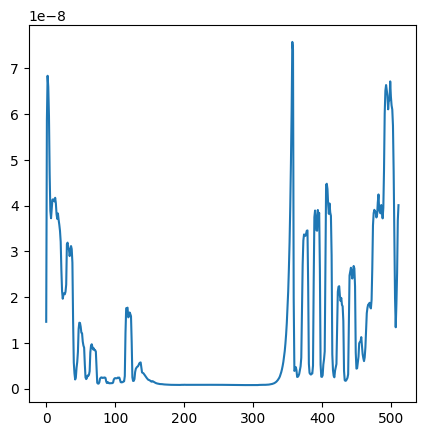

In [49]:
sample_to_plot = 0
helper_functions.plot_image(Xs_arr[sample_to_plot], dim=(224,224), dpi=100)

### To visualize images

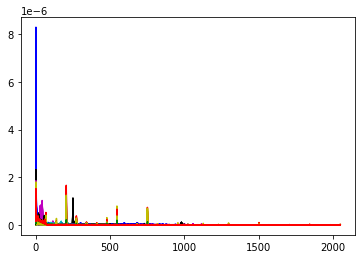

In [7]:
# # plot for each type of drone
# X_norm = Xs
# for n in range(len(Xs_arr)):
#     if DRONES[n] == 'AIR':
#         c = 'r'
#     elif DRONES[n] == 'DIS':
#         c = 'b'
#     elif DRONES[n] == 'INS':
#         c = 'g'
#     elif DRONES[n] == 'MIN':
#         c = 'c'
#     elif DRONES[n] == 'MP1':
#         c = 'm'
#     elif DRONES[n] == 'MP2':
#         c = 'k'
#     elif DRONES[n] == 'PHA':
#         c = 'y'
    
#     # normalize it
# #     X_norm[n] = Xs[n]/max(Xs[n])
#     plt.plot(Xs[n],color=c)